# Comprehensive Performance Benchmark: fftvis vs matvis

This notebook benchmarks the performance of fftvis (both CPU and GPU backends) against matvis across various parameter configurations to understand scaling behavior and speedup factors.

## Setup and Imports

In [1]:
# Standard imports
import numpy as np
import healpy as hp
from astropy.time import Time
import matplotlib.pyplot as plt
import time
import pandas as pd
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# HERA-stack imports
import fftvis
import matvis
from hera_sim.antpos import hex_array
from pyuvdata.telescopes import Telescope
from pyuvdata.analytic_beam import AiryBeam

# Ray for multiprocessing
import ray
if ray.is_initialized():
    ray.shutdown()

# GPU imports
try:
    import cupy as cp
    from fftvis.gpu.nufft import HAVE_CUFINUFFT
    GPU_AVAILABLE = cp.cuda.is_available() and HAVE_CUFINUFFT
    if GPU_AVAILABLE:
        print(f"✅ GPU is available with {cp.cuda.runtime.getDeviceCount()} device(s)")
        # Get GPU memory info
        mempool = cp.get_default_memory_pool()
        device = cp.cuda.Device(0)
        total_memory = device.mem_info[1] / 1e9
        print(f"   Total GPU memory: {total_memory:.1f} GB")
    else:
        print("❌ GPU not available")
except ImportError:
    GPU_AVAILABLE = False
    print("❌ GPU dependencies not installed")

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

✅ GPU is available with 1 device(s)
   Total GPU memory: 2.1 GB


## Define Base Configuration

In [2]:
# Base telescope configuration
def create_base_config(nants: int = 15) -> Dict:
    """Create base configuration for simulations."""
    
    # Antenna positions
    if nants <= 15:
        antpos = hex_array(3, split_core=True, outriggers=0)
    elif nants <= 37:
        antpos = hex_array(4, split_core=True, outriggers=0)
    else:
        antpos = hex_array(5, split_core=True, outriggers=0)
    
    # Select subset of antennas if needed
    if len(antpos) > nants:
        antpos = {i: antpos[i] for i in range(nants)}
    
    # Create beam - just use AiryBeam directly
    beam = AiryBeam(diameter=14.0)
    
    # Telescope location
    telescope_loc = Telescope.from_known_telescopes('hera').location
    
    # Baselines
    baselines = [(i, j) for i in range(len(antpos)) for j in range(i, len(antpos))]
    
    return {
        'antpos': antpos,
        'beam': beam,
        'telescope_loc': telescope_loc,
        'baselines': baselines,
        'nants': len(antpos),
        'nbls': len(baselines)
    }

# Test base configuration
base_config = create_base_config()
print(f"Base configuration created with {base_config['nants']} antennas and {base_config['nbls']} baselines")

Base configuration created with 15 antennas and 120 baselines


## Define Sky Model Generator

In [3]:
def create_sky_model(nside: int, freqs: np.ndarray, seed: int = 42) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Create a HEALPix-based sky model.
    
    Parameters
    ----------
    nside : int
        HEALPix nside parameter
    freqs : np.ndarray
        Frequency array in Hz
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    ra : np.ndarray
        Right ascension in radians
    dec : np.ndarray
        Declination in radians  
    flux_allfreq : np.ndarray
        Flux array with shape (nsources, nfreqs)
    """
    np.random.seed(seed)
    
    nsource = hp.nside2npix(nside)
    
    # Get HEALPix coordinates
    dec, ra = hp.pix2ang(nside, np.arange(nsource))
    dec -= np.pi / 2
    
    # Generate flux with power-law spectrum
    flux = np.random.uniform(0, 1, nsource)
    alpha = np.ones(nsource) * -0.8  # Spectral index
    
    # Calculate flux at all frequencies
    flux_allfreq = ((freqs[:, np.newaxis] / freqs[0]) ** alpha.T * flux.T).T
    
    return ra, dec, flux_allfreq

## Define Benchmark Function

In [4]:
def benchmark_single_config(
    config: Dict,
    nside: int,
    ntimes: int,
    nfreqs: int,
    backends: List[str] = ['matvis', 'fftvis_cpu', 'fftvis_gpu'],
    n_runs: int = 3,
    precision: int = 2
) -> Dict[str, float]:
    """Benchmark a single configuration across different backends.
    
    Parameters
    ----------
    config : Dict
        Base telescope configuration
    nside : int
        HEALPix nside for sky model
    ntimes : int
        Number of time samples
    nfreqs : int
        Number of frequency channels
    backends : List[str]
        List of backends to benchmark
    n_runs : int
        Number of runs for timing (best of n_runs)
    precision : int
        Precision setting (1 for float32, 2 for float64)
        
    Returns
    -------
    results : Dict[str, float]
        Timing results for each backend
    """
    # Create observation parameters
    freqs = np.linspace(100e6, 120e6, nfreqs)
    times = Time(np.linspace(2459845, 2459845 + 0.1 * ntimes / 288, ntimes), format='jd', scale='utc')
    
    # Create sky model
    ra, dec, flux_allfreq = create_sky_model(nside, freqs)
    nsources = len(ra)
    
    results = {
        'nside': nside,
        'nsources': nsources,
        'ntimes': ntimes,
        'nfreqs': nfreqs,
        'nants': config['nants'],
        'nbls': config['nbls']
    }
    
    # Benchmark matvis
    if 'matvis' in backends:
        print(f"  Benchmarking matvis...", end='', flush=True)
        times_matvis = []
        for _ in range(n_runs):
            t0 = time.perf_counter()
            _ = matvis.simulate_vis(
                ants=config['antpos'],
                fluxes=flux_allfreq,
                ra=ra,
                dec=dec,
                freqs=freqs,
                times=times,
                telescope_loc=config['telescope_loc'],
                beams=[config['beam']],
                polarized=False,
                precision=precision,
            )
            times_matvis.append(time.perf_counter() - t0)
        results['matvis'] = min(times_matvis)
        print(f" {results['matvis']:.2f}s")
    
    # Benchmark fftvis CPU
    if 'fftvis_cpu' in backends:
        print(f"  Benchmarking fftvis CPU...", end='', flush=True)
        times_cpu = []
        for _ in range(n_runs):
            t0 = time.perf_counter()
            _ = fftvis.simulate_vis(
                ants=config['antpos'],
                fluxes=flux_allfreq,
                ra=ra,
                dec=dec,
                freqs=freqs,
                times=times.jd,
                telescope_loc=config['telescope_loc'],
                beam=config['beam'],
                polarized=False,
                precision=precision,
                nprocesses=1,
                baselines=config['baselines'],
                backend="cpu"
            )
            times_cpu.append(time.perf_counter() - t0)
        results['fftvis_cpu'] = min(times_cpu)
        print(f" {results['fftvis_cpu']:.2f}s")
    
    # Benchmark fftvis GPU
    if 'fftvis_gpu' in backends and GPU_AVAILABLE:
        print(f"  Benchmarking fftvis GPU...", end='', flush=True)
        times_gpu = []
        for _ in range(n_runs):
            t0 = time.perf_counter()
            _ = fftvis.simulate_vis(
                ants=config['antpos'],
                fluxes=flux_allfreq,
                ra=ra,
                dec=dec,
                freqs=freqs,
                times=times.jd,
                telescope_loc=config['telescope_loc'],
                beam=config['beam'],
                polarized=False,
                precision=precision,
                nprocesses=1,
                baselines=config['baselines'],
                backend="gpu"
            )
            times_gpu.append(time.perf_counter() - t0)
            # Clear GPU memory
            cp.cuda.runtime.deviceSynchronize()
            cp.get_default_memory_pool().free_all_blocks()
        results['fftvis_gpu'] = min(times_gpu)
        print(f" {results['fftvis_gpu']:.2f}s")
    elif 'fftvis_gpu' in backends:
        results['fftvis_gpu'] = np.nan
        print(" GPU not available")
    
    return results

## Benchmark 1: Scaling with Number of Sources

In [5]:
# Fixed parameters
FIXED_NTIMES = 10
FIXED_NFREQS = 10
FIXED_NANTS = 15

# Variable parameter
nsides = [8, 16, 32, 64, 128]

print("Benchmarking scaling with number of sources...")
print(f"Fixed: ntimes={FIXED_NTIMES}, nfreqs={FIXED_NFREQS}, nants={FIXED_NANTS}")
print("-" * 60)

source_scaling_results = []
config = create_base_config(FIXED_NANTS)

for nside in nsides:
    nsources = hp.nside2npix(nside)
    print(f"\nnside={nside} ({nsources} sources):")
    
    result = benchmark_single_config(
        config=config,
        nside=nside,
        ntimes=FIXED_NTIMES,
        nfreqs=FIXED_NFREQS,
        n_runs=2
    )
    source_scaling_results.append(result)

# Convert to DataFrame for easier analysis
df_sources = pd.DataFrame(source_scaling_results)
df_sources['fftvis_cpu_speedup'] = df_sources['matvis'] / df_sources['fftvis_cpu']
if GPU_AVAILABLE:
    df_sources['fftvis_gpu_speedup'] = df_sources['matvis'] / df_sources['fftvis_gpu']
    df_sources['gpu_vs_cpu'] = df_sources['fftvis_cpu'] / df_sources['fftvis_gpu']

Benchmarking scaling with number of sources...
Fixed: ntimes=10, nfreqs=10, nants=15
------------------------------------------------------------

nside=8 (768 sources):
 0.31shmarking matvis...
 1.03shmarking fftvis CPU...
 0.40shmarking fftvis GPU...

nside=16 (3072 sources):
 0.47shmarking matvis...
 1.05shmarking fftvis CPU...
 0.41shmarking fftvis GPU...

nside=32 (12288 sources):
 1.49shmarking matvis...
 1.27shmarking fftvis CPU...
 0.51shmarking fftvis GPU...

nside=64 (49152 sources):
 4.99shmarking matvis...
 1.38shmarking fftvis CPU...
 1.01shmarking fftvis GPU...

nside=128 (196608 sources):
 15.19smarking matvis...
 3.25shmarking fftvis CPU...
 3.81shmarking fftvis GPU...


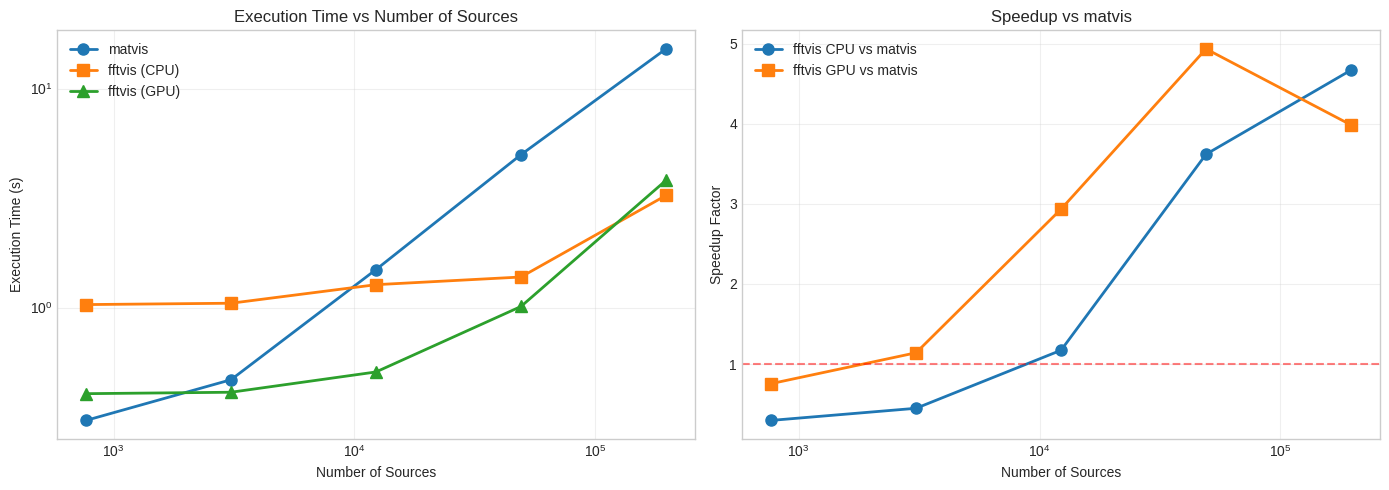


Source Scaling Summary:


,nsources,matvis,fftvis_cpu,fftvis_gpu,fftvis_cpu_speedup,fftvis_gpu_speedup
0,768,0.31,1.03,0.40,0.30,0.75
1,3072,0.47,1.05,0.41,0.45,1.14
2,12288,1.49,1.27,0.51,1.17,2.93
3,49152,4.99,1.38,1.01,3.62,4.94
4,196608,15.19,3.25,3.81,4.67,3.99


In [6]:
# Plot source scaling results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Execution time plot
ax1.loglog(df_sources['nsources'], df_sources['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
ax1.loglog(df_sources['nsources'], df_sources['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax1.loglog(df_sources['nsources'], df_sources['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)

ax1.set_xlabel('Number of Sources')
ax1.set_ylabel('Execution Time (s)')
ax1.set_title('Execution Time vs Number of Sources')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup plot
ax2.semilogx(df_sources['nsources'], df_sources['fftvis_cpu_speedup'], 'o-', 
             label='fftvis CPU vs matvis', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax2.semilogx(df_sources['nsources'], df_sources['fftvis_gpu_speedup'], 's-', 
                 label='fftvis GPU vs matvis', linewidth=2, markersize=8)

ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Sources')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup vs matvis')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary table
print("\nSource Scaling Summary:")
display(df_sources[['nsources', 'matvis', 'fftvis_cpu', 'fftvis_gpu', 
                    'fftvis_cpu_speedup', 'fftvis_gpu_speedup']].round(2))

## Benchmark 2: Scaling with Number of Times

In [7]:
# Fixed parameters
FIXED_NSIDE = 32  # ~12k sources
FIXED_NFREQS = 10
FIXED_NANTS = 15

# Variable parameter
ntimes_list = [5, 10, 20, 40, 80]

print("Benchmarking scaling with number of times...")
print(f"Fixed: nside={FIXED_NSIDE} ({hp.nside2npix(FIXED_NSIDE)} sources), nfreqs={FIXED_NFREQS}, nants={FIXED_NANTS}")
print("-" * 60)

time_scaling_results = []
config = create_base_config(FIXED_NANTS)

for ntimes in ntimes_list:
    print(f"\nntimes={ntimes}:")
    
    result = benchmark_single_config(
        config=config,
        nside=FIXED_NSIDE,
        ntimes=ntimes,
        nfreqs=FIXED_NFREQS,
        n_runs=2
    )
    time_scaling_results.append(result)

# Convert to DataFrame
df_times = pd.DataFrame(time_scaling_results)
df_times['fftvis_cpu_speedup'] = df_times['matvis'] / df_times['fftvis_cpu']
if GPU_AVAILABLE:
    df_times['fftvis_gpu_speedup'] = df_times['matvis'] / df_times['fftvis_gpu']
    df_times['gpu_vs_cpu'] = df_times['fftvis_cpu'] / df_times['fftvis_gpu']

Benchmarking scaling with number of times...
Fixed: nside=32 (12288 sources), nfreqs=10, nants=15
------------------------------------------------------------

ntimes=5:
 0.56shmarking matvis...
 0.60shmarking fftvis CPU...
 0.26shmarking fftvis GPU...

ntimes=10:
 1.11shmarking matvis...
 1.18shmarking fftvis CPU...
 0.51shmarking fftvis GPU...

ntimes=20:
 2.20shmarking matvis...
 2.41shmarking fftvis CPU...
 1.00shmarking fftvis GPU...

ntimes=40:
 6.01shmarking matvis...
 5.71shmarking fftvis CPU...
 2.00shmarking fftvis GPU...

ntimes=80:
 11.89smarking matvis...
 10.44smarking fftvis CPU...
 4.02shmarking fftvis GPU...


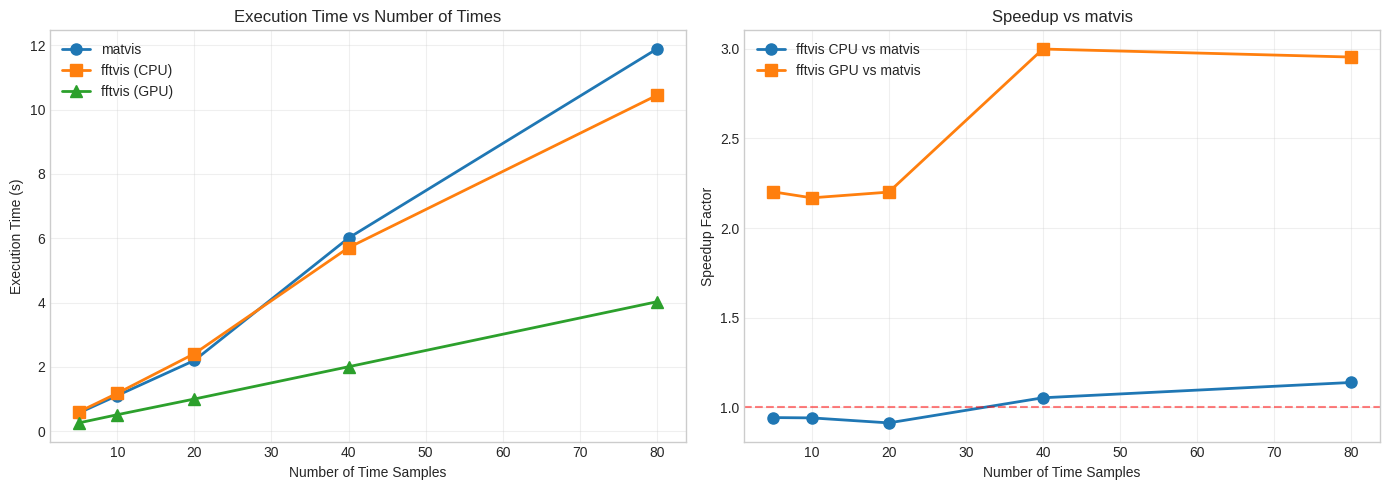


Time Scaling Summary:


,ntimes,matvis,fftvis_cpu,fftvis_gpu,fftvis_cpu_speedup,fftvis_gpu_speedup
0,5,0.56,0.60,0.26,0.94,2.20
1,10,1.11,1.18,0.51,0.94,2.17
2,20,2.20,2.41,1.00,0.91,2.20
3,40,6.01,5.71,2.00,1.05,3.00
4,80,11.89,10.44,4.02,1.14,2.95


In [8]:
# Plot time scaling results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Execution time plot
ax1.plot(df_times['ntimes'], df_times['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
ax1.plot(df_times['ntimes'], df_times['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax1.plot(df_times['ntimes'], df_times['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)

ax1.set_xlabel('Number of Time Samples')
ax1.set_ylabel('Execution Time (s)')
ax1.set_title('Execution Time vs Number of Times')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup plot
ax2.plot(df_times['ntimes'], df_times['fftvis_cpu_speedup'], 'o-', 
         label='fftvis CPU vs matvis', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax2.plot(df_times['ntimes'], df_times['fftvis_gpu_speedup'], 's-', 
             label='fftvis GPU vs matvis', linewidth=2, markersize=8)

ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Time Samples')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup vs matvis')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary table
print("\nTime Scaling Summary:")
display(df_times[['ntimes', 'matvis', 'fftvis_cpu', 'fftvis_gpu', 
                  'fftvis_cpu_speedup', 'fftvis_gpu_speedup']].round(2))

## Benchmark 3: Scaling with Number of Frequencies

In [9]:
# Fixed parameters
FIXED_NSIDE = 32  # ~12k sources
FIXED_NTIMES = 10
FIXED_NANTS = 15

# Variable parameter
nfreqs_list = [5, 10, 20, 40, 80]

print("Benchmarking scaling with number of frequencies...")
print(f"Fixed: nside={FIXED_NSIDE} ({hp.nside2npix(FIXED_NSIDE)} sources), ntimes={FIXED_NTIMES}, nants={FIXED_NANTS}")
print("-" * 60)

freq_scaling_results = []
config = create_base_config(FIXED_NANTS)

for nfreqs in nfreqs_list:
    print(f"\nnfreqs={nfreqs}:")
    
    result = benchmark_single_config(
        config=config,
        nside=FIXED_NSIDE,
        ntimes=FIXED_NTIMES,
        nfreqs=nfreqs,
        n_runs=2
    )
    freq_scaling_results.append(result)

# Convert to DataFrame
df_freqs = pd.DataFrame(freq_scaling_results)
df_freqs['fftvis_cpu_speedup'] = df_freqs['matvis'] / df_freqs['fftvis_cpu']
if GPU_AVAILABLE:
    df_freqs['fftvis_gpu_speedup'] = df_freqs['matvis'] / df_freqs['fftvis_gpu']
    df_freqs['gpu_vs_cpu'] = df_freqs['fftvis_cpu'] / df_freqs['fftvis_gpu']

Benchmarking scaling with number of frequencies...
Fixed: nside=32 (12288 sources), ntimes=10, nants=15
------------------------------------------------------------

nfreqs=5:
 0.76shmarking matvis...
 0.72shmarking fftvis CPU...
 0.27shmarking fftvis GPU...

nfreqs=10:
 1.46shmarking matvis...
 1.12shmarking fftvis CPU...
 0.50shmarking fftvis GPU...

nfreqs=20:
 2.16shmarking matvis...
 2.41shmarking fftvis CPU...
 1.16shmarking fftvis GPU...

nfreqs=40:
 4.27shmarking matvis...
 4.78shmarking fftvis CPU...
 2.20shmarking fftvis GPU...

nfreqs=80:
 8.65shmarking matvis...
 10.35smarking fftvis CPU...
 9.15shmarking fftvis GPU...


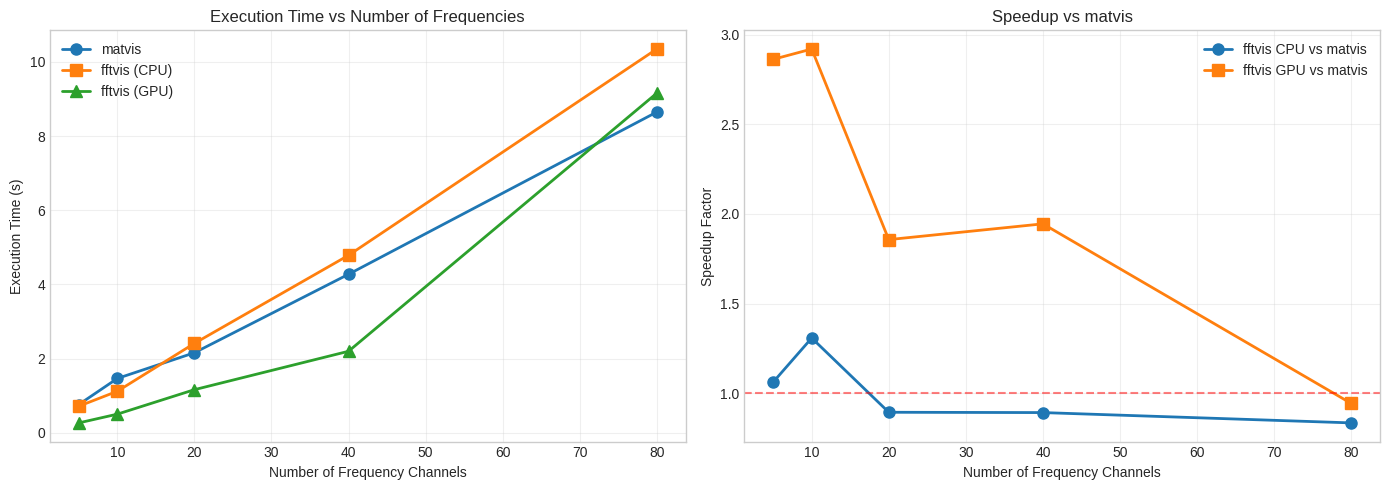


Frequency Scaling Summary:


,nfreqs,matvis,fftvis_cpu,fftvis_gpu,fftvis_cpu_speedup,fftvis_gpu_speedup
0,5,0.76,0.72,0.27,1.06,2.86
1,10,1.46,1.12,0.50,1.31,2.92
2,20,2.16,2.41,1.16,0.89,1.86
3,40,4.27,4.78,2.20,0.89,1.95
4,80,8.65,10.35,9.15,0.84,0.94


In [10]:
# Plot frequency scaling results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Execution time plot
ax1.plot(df_freqs['nfreqs'], df_freqs['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
ax1.plot(df_freqs['nfreqs'], df_freqs['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax1.plot(df_freqs['nfreqs'], df_freqs['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)

ax1.set_xlabel('Number of Frequency Channels')
ax1.set_ylabel('Execution Time (s)')
ax1.set_title('Execution Time vs Number of Frequencies')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup plot
ax2.plot(df_freqs['nfreqs'], df_freqs['fftvis_cpu_speedup'], 'o-', 
         label='fftvis CPU vs matvis', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax2.plot(df_freqs['nfreqs'], df_freqs['fftvis_gpu_speedup'], 's-', 
             label='fftvis GPU vs matvis', linewidth=2, markersize=8)

ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Frequency Channels')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup vs matvis')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary table
print("\nFrequency Scaling Summary:")
display(df_freqs[['nfreqs', 'matvis', 'fftvis_cpu', 'fftvis_gpu', 
                  'fftvis_cpu_speedup', 'fftvis_gpu_speedup']].round(2))

## Benchmark 4: Scaling with Number of Antennas/Baselines

In [11]:
# Fixed parameters
FIXED_NSIDE = 32  # ~12k sources
FIXED_NTIMES = 10
FIXED_NFREQS = 10

# Variable parameter
nants_list = [7, 15, 25, 37]

print("Benchmarking scaling with number of antennas...")
print(f"Fixed: nside={FIXED_NSIDE} ({hp.nside2npix(FIXED_NSIDE)} sources), ntimes={FIXED_NTIMES}, nfreqs={FIXED_NFREQS}")
print("-" * 60)

ant_scaling_results = []

for nants in nants_list:
    config = create_base_config(nants)
    print(f"\nnants={nants} ({config['nbls']} baselines):")
    
    result = benchmark_single_config(
        config=config,
        nside=FIXED_NSIDE,
        ntimes=FIXED_NTIMES,
        nfreqs=FIXED_NFREQS,
        n_runs=2
    )
    ant_scaling_results.append(result)

# Convert to DataFrame
df_ants = pd.DataFrame(ant_scaling_results)
df_ants['fftvis_cpu_speedup'] = df_ants['matvis'] / df_ants['fftvis_cpu']
if GPU_AVAILABLE:
    df_ants['fftvis_gpu_speedup'] = df_ants['matvis'] / df_ants['fftvis_gpu']
    df_ants['gpu_vs_cpu'] = df_ants['fftvis_cpu'] / df_ants['fftvis_gpu']

Benchmarking scaling with number of antennas...
Fixed: nside=32 (12288 sources), ntimes=10, nfreqs=10
------------------------------------------------------------

nants=7 (28 baselines):
 0.85shmarking matvis...
 1.09shmarking fftvis CPU...
 0.51shmarking fftvis GPU...

nants=15 (120 baselines):
 1.45shmarking matvis...
 1.23shmarking fftvis CPU...
 0.51shmarking fftvis GPU...

nants=25 (325 baselines):
 1.86shmarking matvis...
 1.13shmarking fftvis CPU...
 0.55shmarking fftvis GPU...

nants=37 (561 baselines):
 2.19shmarking matvis...
 1.16shmarking fftvis CPU...
 0.56shmarking fftvis GPU...


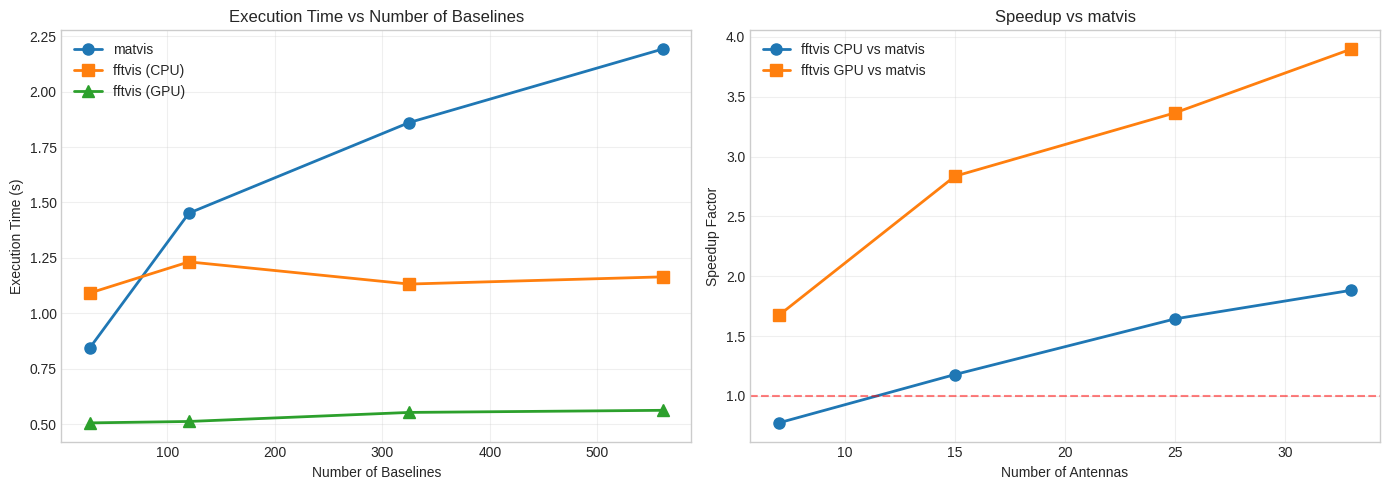


Antenna/Baseline Scaling Summary:


,nants,nbls,matvis,fftvis_cpu,fftvis_gpu,fftvis_cpu_speedup,fftvis_gpu_speedup
0,7,28,0.85,1.09,0.51,0.77,1.67
1,15,120,1.45,1.23,0.51,1.18,2.84
2,25,325,1.86,1.13,0.55,1.64,3.37
3,33,561,2.19,1.16,0.56,1.88,3.90


In [12]:
# Plot antenna/baseline scaling results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Execution time plot vs baselines
ax1.plot(df_ants['nbls'], df_ants['matvis'], 'o-', label='matvis', linewidth=2, markersize=8)
ax1.plot(df_ants['nbls'], df_ants['fftvis_cpu'], 's-', label='fftvis (CPU)', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax1.plot(df_ants['nbls'], df_ants['fftvis_gpu'], '^-', label='fftvis (GPU)', linewidth=2, markersize=8)

ax1.set_xlabel('Number of Baselines')
ax1.set_ylabel('Execution Time (s)')
ax1.set_title('Execution Time vs Number of Baselines')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Speedup plot vs antennas
ax2.plot(df_ants['nants'], df_ants['fftvis_cpu_speedup'], 'o-', 
         label='fftvis CPU vs matvis', linewidth=2, markersize=8)
if GPU_AVAILABLE:
    ax2.plot(df_ants['nants'], df_ants['fftvis_gpu_speedup'], 's-', 
             label='fftvis GPU vs matvis', linewidth=2, markersize=8)

ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Antennas')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup vs matvis')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary table
print("\nAntenna/Baseline Scaling Summary:")
display(df_ants[['nants', 'nbls', 'matvis', 'fftvis_cpu', 'fftvis_gpu', 
                 'fftvis_cpu_speedup', 'fftvis_gpu_speedup']].round(2))

## Comprehensive Scaling Analysis

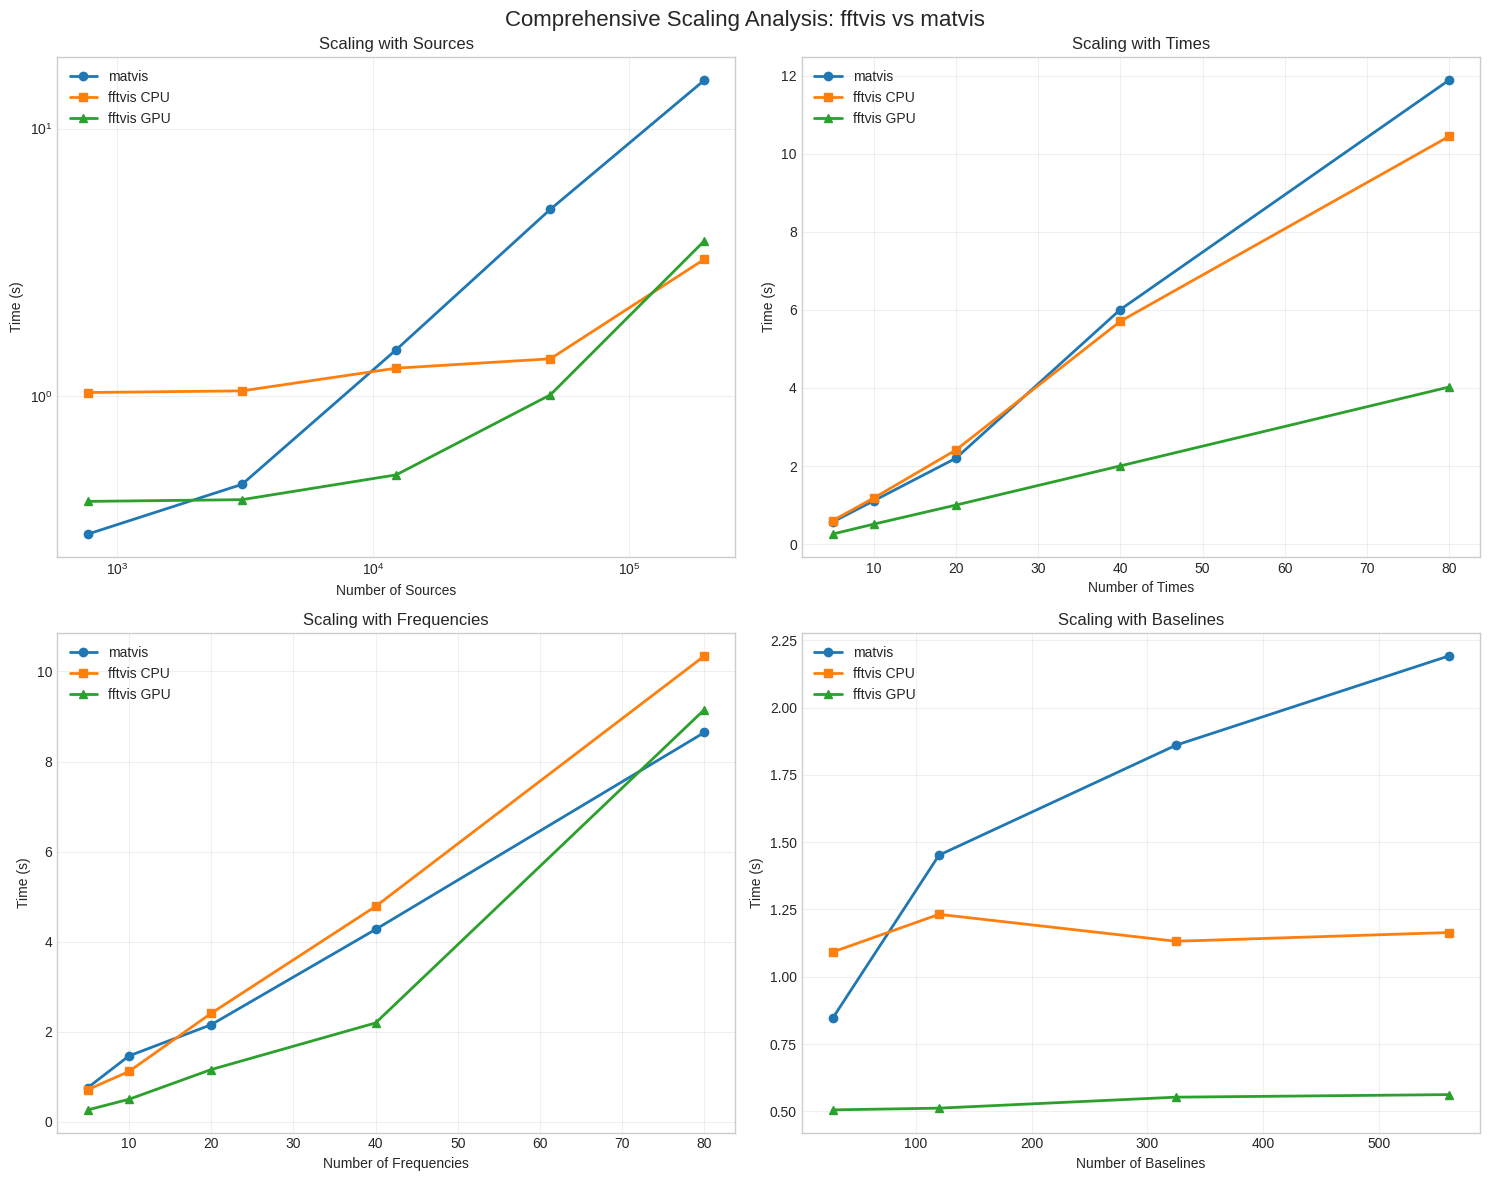

In [13]:
# Create a comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sources scaling
ax = axes[0, 0]
ax.loglog(df_sources['nsources'], df_sources['matvis'], 'o-', label='matvis', linewidth=2)
ax.loglog(df_sources['nsources'], df_sources['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
if GPU_AVAILABLE:
    ax.loglog(df_sources['nsources'], df_sources['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
ax.set_xlabel('Number of Sources')
ax.set_ylabel('Time (s)')
ax.set_title('Scaling with Sources')
ax.legend()
ax.grid(True, alpha=0.3)

# Times scaling
ax = axes[0, 1]
ax.plot(df_times['ntimes'], df_times['matvis'], 'o-', label='matvis', linewidth=2)
ax.plot(df_times['ntimes'], df_times['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
if GPU_AVAILABLE:
    ax.plot(df_times['ntimes'], df_times['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
ax.set_xlabel('Number of Times')
ax.set_ylabel('Time (s)')
ax.set_title('Scaling with Times')
ax.legend()
ax.grid(True, alpha=0.3)

# Frequencies scaling
ax = axes[1, 0]
ax.plot(df_freqs['nfreqs'], df_freqs['matvis'], 'o-', label='matvis', linewidth=2)
ax.plot(df_freqs['nfreqs'], df_freqs['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
if GPU_AVAILABLE:
    ax.plot(df_freqs['nfreqs'], df_freqs['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
ax.set_xlabel('Number of Frequencies')
ax.set_ylabel('Time (s)')
ax.set_title('Scaling with Frequencies')
ax.legend()
ax.grid(True, alpha=0.3)

# Baselines scaling
ax = axes[1, 1]
ax.plot(df_ants['nbls'], df_ants['matvis'], 'o-', label='matvis', linewidth=2)
ax.plot(df_ants['nbls'], df_ants['fftvis_cpu'], 's-', label='fftvis CPU', linewidth=2)
if GPU_AVAILABLE:
    ax.plot(df_ants['nbls'], df_ants['fftvis_gpu'], '^-', label='fftvis GPU', linewidth=2)
ax.set_xlabel('Number of Baselines')
ax.set_ylabel('Time (s)')
ax.set_title('Scaling with Baselines')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Scaling Analysis: fftvis vs matvis', fontsize=16)
plt.tight_layout()
plt.show()